In [ ]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from feature_engine.selection import DropCorrelatedFeatures

In [2]:
# Загружаем данные
data = pd.read_excel('data/data.xlsx')

In [3]:
# Выведем информацию о данных
print("Общая информация о данных:")
print(f"Размерность: {data.shape}")
print("\nТипы данных:")
print(data.dtypes.value_counts())
print("\nПропуски в данных:")
print(data.isna().sum()[data.isna().sum()>0])

Общая информация о данных:
Размерность: (1001, 214)

Типы данных:
int64      107
float64    107
Name: count, dtype: int64

Пропуски в данных:
MaxPartialCharge       3
MinPartialCharge       3
MaxAbsPartialCharge    3
MinAbsPartialCharge    3
BCUT2D_MWHI            3
BCUT2D_MWLOW           3
BCUT2D_CHGHI           3
BCUT2D_CHGLO           3
BCUT2D_LOGPHI          3
BCUT2D_LOGPLOW         3
BCUT2D_MRHI            3
BCUT2D_MRLOW           3
dtype: int64


In [4]:
# Выведем начальные строки
data.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


В данных отсутсвуют текстовые столбцы. Также присутвуют пропуски которые необходимо заполнить.

In [5]:
non_alnum_cols = [col for col in data.columns if not col.replace('_', '').isalnum()]
print("Проверям на наличие столбцов с не-алфавитно-цифровыми символами в названии:")
print(non_alnum_cols)

Проверям на наличие столбцов с не-алфавитно-цифровыми символами в названии:
['Unnamed: 0', 'IC50, mM', 'CC50, mM']


Были найдены три таких столбца, их необходимо переименовать.

In [6]:
# Убираем запятые в названиях колонок
data = data.rename(columns={'IC50, mM': 'IC50', 'CC50, mM': 'CC50'})

In [7]:
# Заполним пропуски с помощью KNN
imputer = KNNImputer(n_neighbors=3)
data = pd.DataFrame(
    imputer.fit_transform(data),
    columns=data.columns
)

# Проведем анализ данных

In [8]:
# Проверим столбцы которые содержат одно значение
const_cols = [col for col in data.columns if data[col].nunique() == 1]
print(f"Константные столбцы: {const_cols}")

Константные столбцы: ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_thiocyan']


Были найдены константные столбцы, их следует удалить.

In [9]:
# Удаляем найденные столбцы
data = data.drop(columns=const_cols)

In [10]:
# Проверка на дубликаты строк
print(f'Количество полных дубликатов строк: {data.duplicated().sum()}')

Количество полных дубликатов строк: 0


In [11]:
# В данных присутвует столбец "Unnamed: 0" который просто дублирует индексы, его следует удалить
data = data.drop('Unnamed: 0', axis=1)

Целевые переменные должны быть строго больше нуля, это необходимо проверить 

In [12]:
for col in ['IC50', 'CC50', 'SI']:
    n_negative = (data[col] <= 0).sum()
    print(f"{col}: найдено {n_negative} неположительных значений")

IC50: найдено 0 неположительных значений
CC50: найдено 0 неположительных значений
SI: найдено 0 неположительных значений


In [13]:
# Удаляем столбцы с высокой корреляцией
highcorr = DropCorrelatedFeatures(threshold=0.9)
data = highcorr.fit_transform(data)

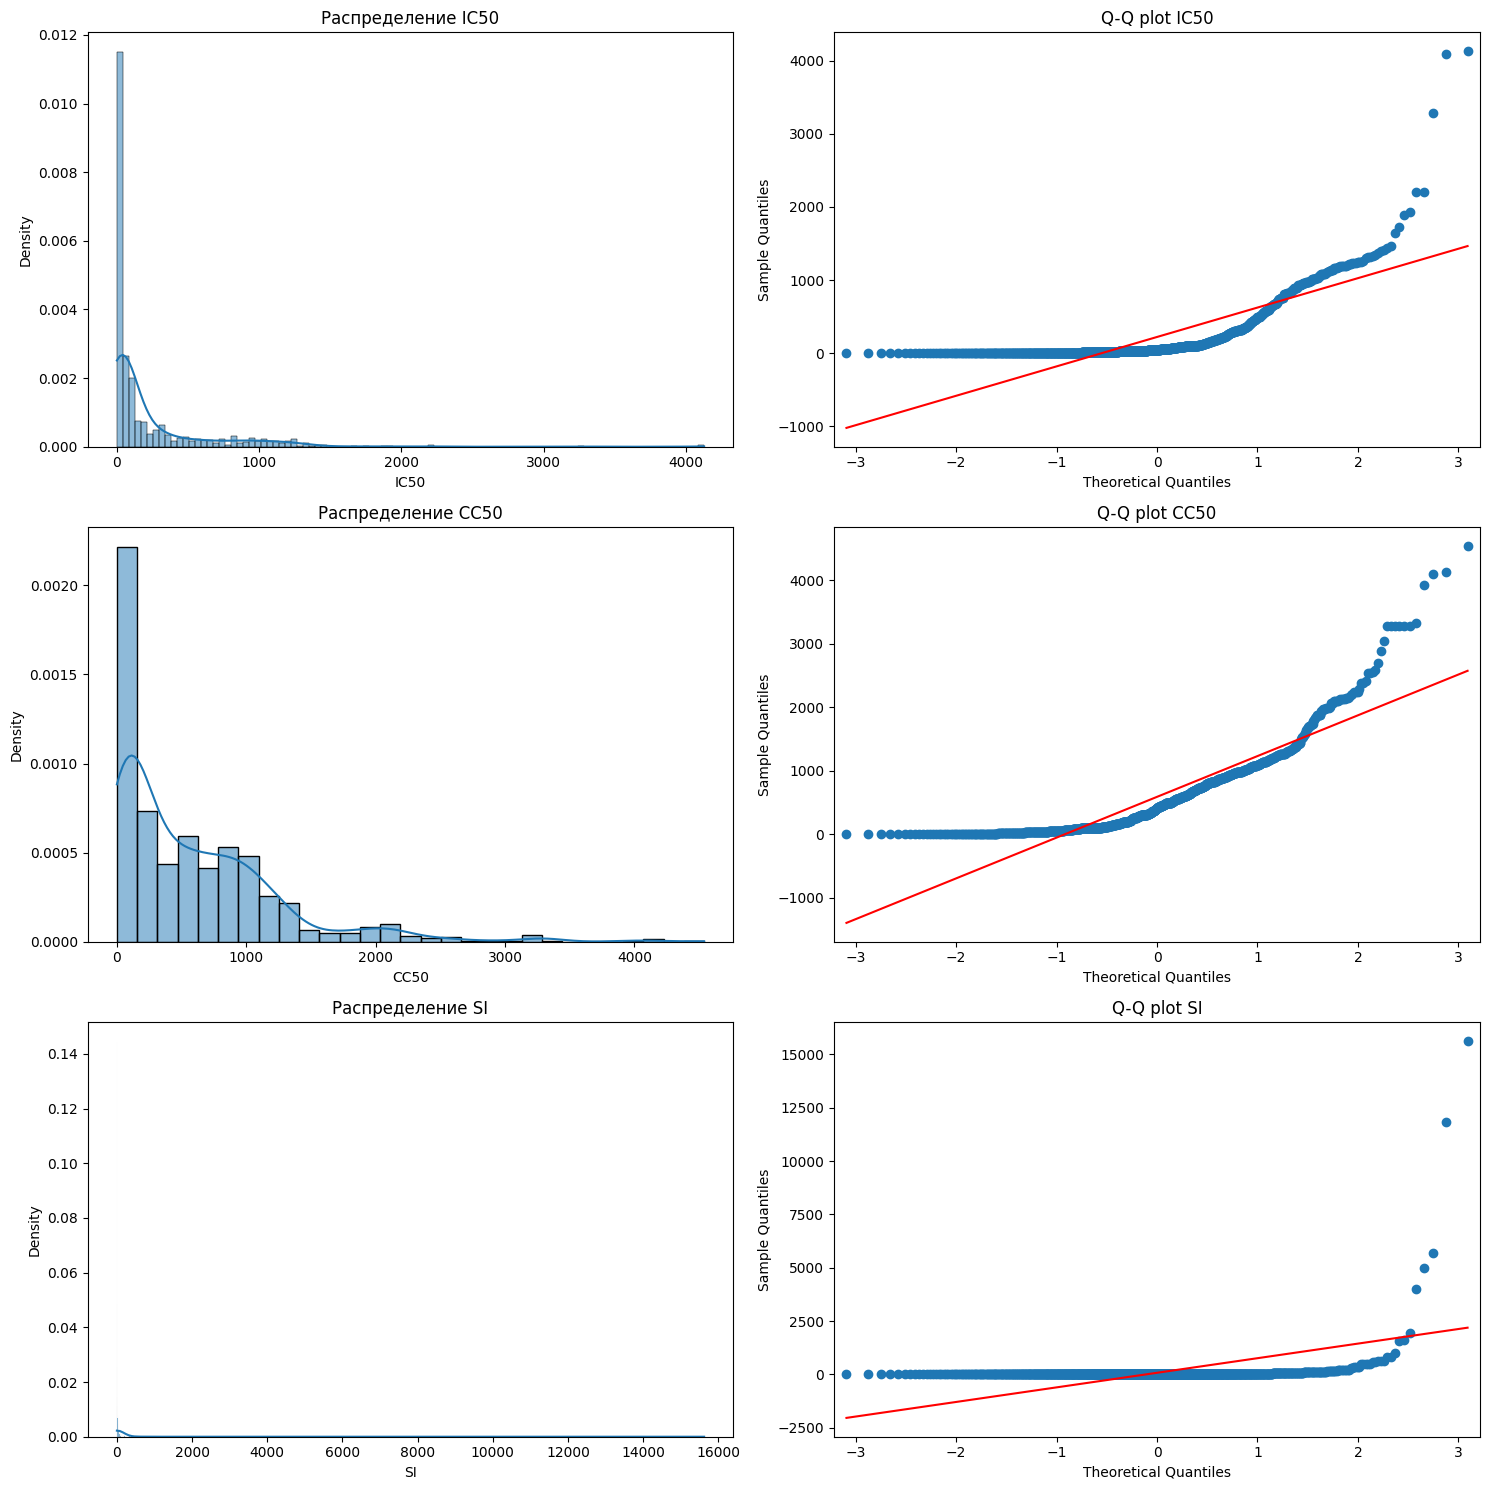

,Переменная,Асимметрия,Эксцесс,p-value
0,IC50,3.67,25.33,0.000000
1,CC50,1.97,8.65,0.000000
2,SI,17.99,362.61,0.000000


In [ ]:
def analyze_distributions(df, columns):
    """
    Анализ распределений указанных числовых признаков:
    - Вычисляет асимметрию, эксцесс и p-value (Шапиро–Уилка) для оценки нормальности
    - Строит гистограммы и Q-Q графики
    - Возвращает таблицу с расчетными метриками
    """
    results = []
    plt.figure(figsize=(15, len(columns)*5))
    
    for i, col in enumerate(columns, 1):
        data = df[col].dropna()
        
        # Расчет статистик
        skew_val = stats.skew(data)
        kurt_val = stats.kurtosis(data, fisher=False)
        _, p = stats.shapiro(data)
        
        results.append({
            'Переменная': col,
            'Асимметрия': f"{skew_val:.2f}",
            'Эксцесс': f"{kurt_val:.2f}",
            'p-value': f"{p:.6f}"
        })
        
        # Гистограмма
        plt.subplot(len(columns), 2, 2*i-1)
        sns.histplot(data, kde=True, stat='density')
        plt.title(f'Распределение {col}')
        
        # Q-Q plot
        plt.subplot(len(columns), 2, 2*i)
        qqplot(data, line='s', ax=plt.gca())
        plt.title(f'Q-Q plot {col}')
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(results)

# Запуск анализа
dist_results = analyze_distributions(data, ['IC50', 'CC50', 'SI'])
display(dist_results)

Все целевые переменные демонстрируют:
* Значительную правостороннюю асимметрию
* Ярко выраженные пики
* Существенное отклонение от нормального распределения

log1p преобразование применено для коррекции правосторонней асимметрии и эксцесса в распределениях целевых переменных, выявленных в предыдущем анализе.

In [15]:
# Создаем преобразованные столбцы
df_log = data.copy()
for col in ['IC50', 'CC50', 'SI']:
    df_log[f'{col}_log'] = np.log1p(df_log[col])

# Удаляем оригинальные столбцы
df_log = df_log.drop(['IC50', 'CC50', 'SI'], axis=1)

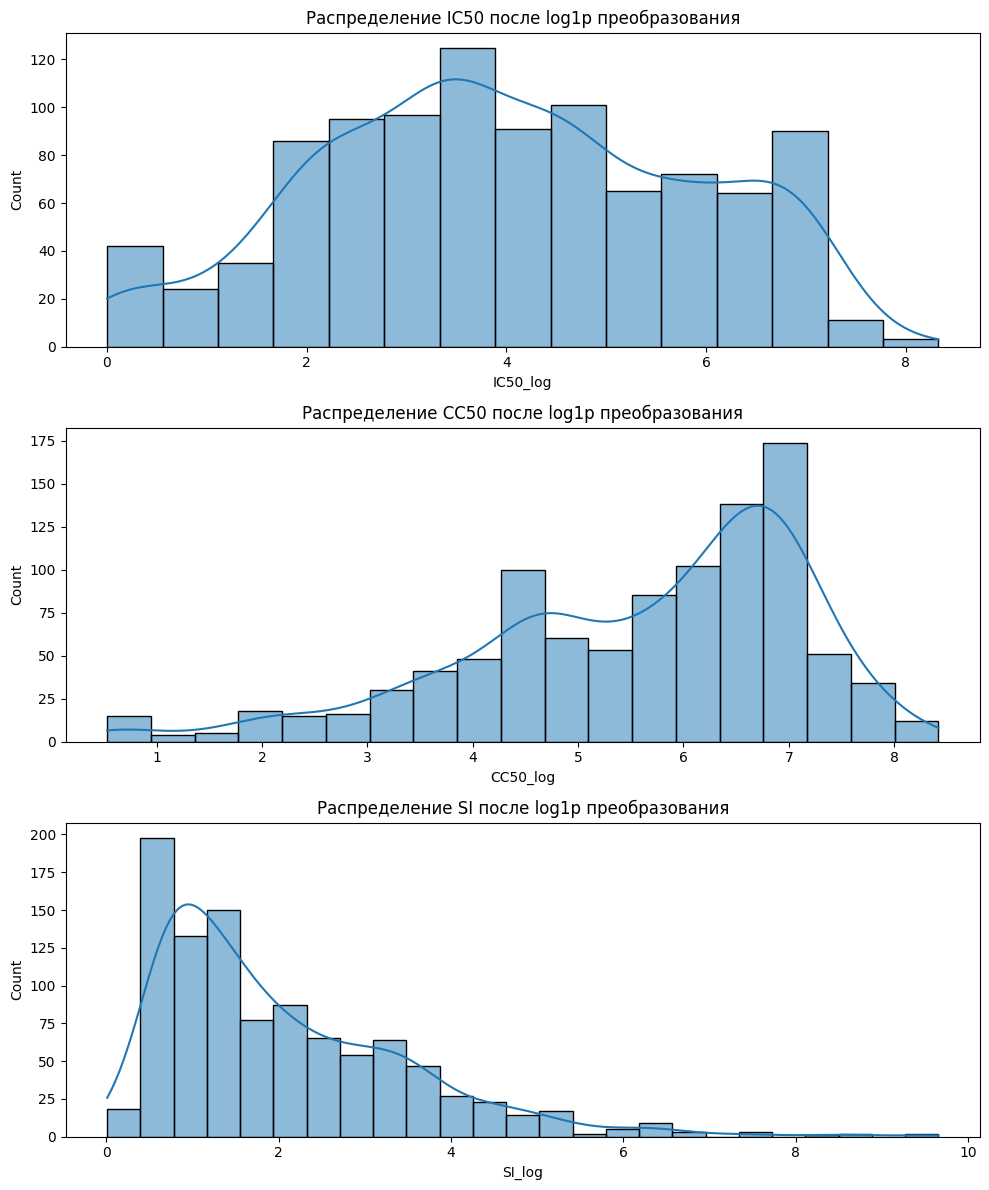

In [16]:
# Создаем графики распределений
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, col in enumerate(['IC50', 'CC50', 'SI']):
    sns.histplot(df_log[f'{col}_log'], kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение {col} после log1p преобразования')
plt.tight_layout()
plt.show()

Для переменных IC50 и CC50 log1p преобразование дало хорошие результаты - асимметрия уменьшилась, распределения стали более сбалансированными. Однако для SI преобразования оказалось недостаточно: сохранились многочисленные выбросы справа и сильная асимметрия.  

Надо проверить подробнее.

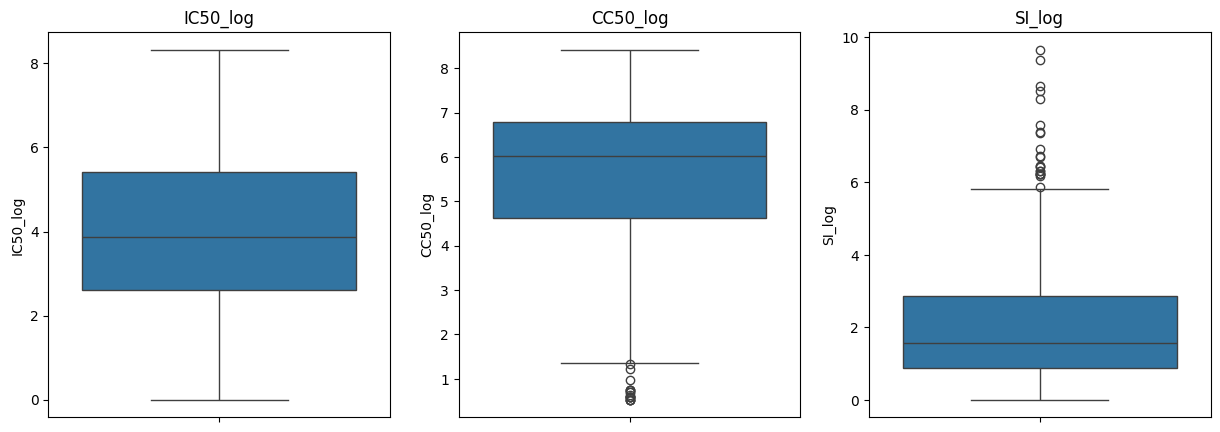

In [17]:
# Создадим боксплот для проверки на выбросы
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y=df_log['IC50_log'], ax=axes[0])
sns.boxplot(y=df_log['CC50_log'], ax=axes[1])
sns.boxplot(y=df_log['SI_log'], ax=axes[2])
axes[0].set_title('IC50_log'); axes[1].set_title('CC50_log'); axes[2].set_title('SI_log')
plt.show()

In [ ]:
# Проверим подробнее
def tail_analysis(series, name):
    """
    Анализ асимметрии распределения на основе хвостов:
    - Вычисляет 5% и 95% перцентили, медиану
    - Оценивает длину левого и правого хвостов (относительно медианы)
    - Возвращает серию с метриками и отношением хвостов (правый / левый)
    """
    q5, q95 = series.quantile(0.05), series.quantile(0.95)
    median = series.median()
    left_tail = median - q5
    right_tail = q95 - median
    
    return pd.Series({
        'Переменная': name,
        '5% перцентиль': q5,
        'Медиана': median,
        '95% перцентиль': q95,
        'Левый хвост (медиана - q5)': left_tail,
        'Правый хвост (q95 - медиана)': right_tail,
        'Отношение хвостов (правый/левый)': right_tail/left_tail,
    })

# Применяем анализ ко всем переменным
tail_stats = pd.concat([
    tail_analysis(df_log['IC50_log'], 'IC50_log'),
    tail_analysis(df_log['CC50_log'], 'CC50_log'), 
    tail_analysis(df_log['SI_log'], 'SI_log')
], axis=1).T

display(tail_stats)

,Переменная,5% перцентиль,Медиана,95% перцентиль,Левый хвост (медиана - q5),Правый хвост (q95 - медиана),Отношение хвостов (правый/левый)
0,IC50_log,0.87532,3.862521,6.982576,2.987201,3.120054,1.044474
1,CC50_log,2.37849,6.021119,7.569079,3.642629,1.547961,0.424957
2,SI_log,0.686878,1.578185,4.741765,0.891308,3.16358,3.549368


1. **IC50_log**:
   * Отношение хвостов ≈ 1 - распределение симметричное
   * Дополнительная обработка не требуется

2. **CC50_log**:
   * Явный левый хвост (отношение 0.425 < 0.67)
   * 5% значений ниже 2.378 (при медиане 3.812)
   * Для корректирования уберем значения ниже 5% перцентиля

3. **SI_log**:
   * Экстремальный правый хвост (отношение 3.549 > 1.5)
   * 5% значений выше 4.742 (при медиане 1.150) 
   * Для корректирования обрежем по IQR

In [ ]:
# Создаём копию данных
df_cleaned = df_log.copy()

# Вычисляем границы один раз
cc50_cutoff = df_cleaned['CC50_log'].quantile(0.05)
q1_si, q3_si = df_cleaned['SI_log'].quantile([0.25, 0.75])
iqr_si = q3_si - q1_si
si_cutoff = q3_si + 1.5 * iqr_si

# Создаём маски фильтрации
cc50_mask = df_cleaned['CC50_log'] >= cc50_cutoff
si_mask = df_cleaned['SI_log'] <= si_cutoff

# Сохраняем размер до обработки
original_size = len(df_cleaned)

# Фильтруем данные
df_cleaned = df_cleaned[cc50_mask & si_mask].copy()

# Расчитываем удалённые строки
removed_rows = original_size - len(df_cleaned)

### Результаты обработки данных

1. **Применено log1p преобразование** для всех целевых переменных:
   * IC50 → IC50_log
   * CC50 → CC50_log
   * SI → SI_log

2. **Удаление выбросов**:
   * Для CC50_log: обрезка левого хвоста (5% перцентиль)
   * Для SI_log: обрезка правого хвоста (метод IQR)
   * IC50_log оставлен без изменений

3. **Данные готовы для дальнейшего анализа и моделирования**

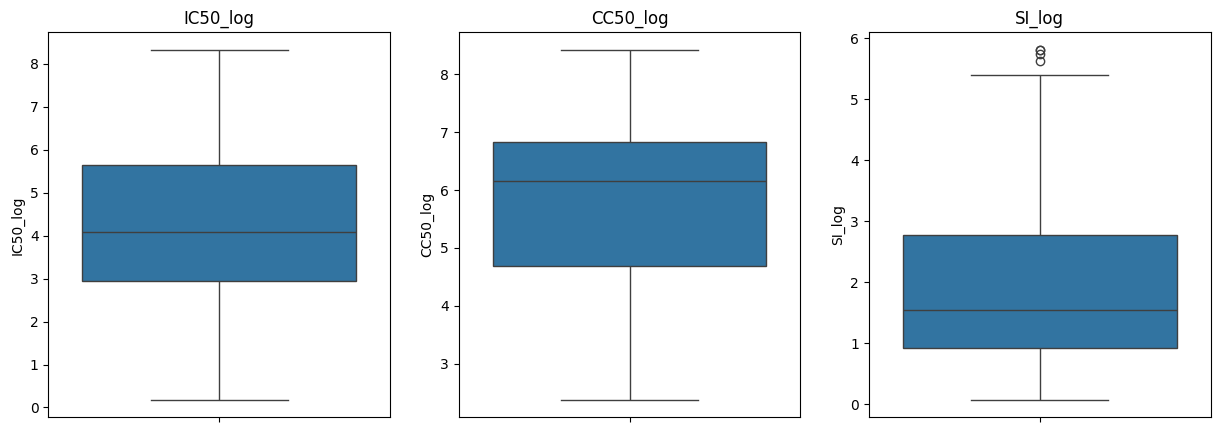

In [ ]:
# Создаем boxplot графики выбросов в log1p-преобразованных переменных
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y=df_cleaned['IC50_log'], ax=axes[0])
sns.boxplot(y=df_cleaned['CC50_log'], ax=axes[1])
sns.boxplot(y=df_cleaned['SI_log'], ax=axes[2])
axes[0].set_title('IC50_log'); axes[1].set_title('CC50_log'); axes[2].set_title('SI_log')
plt.show()

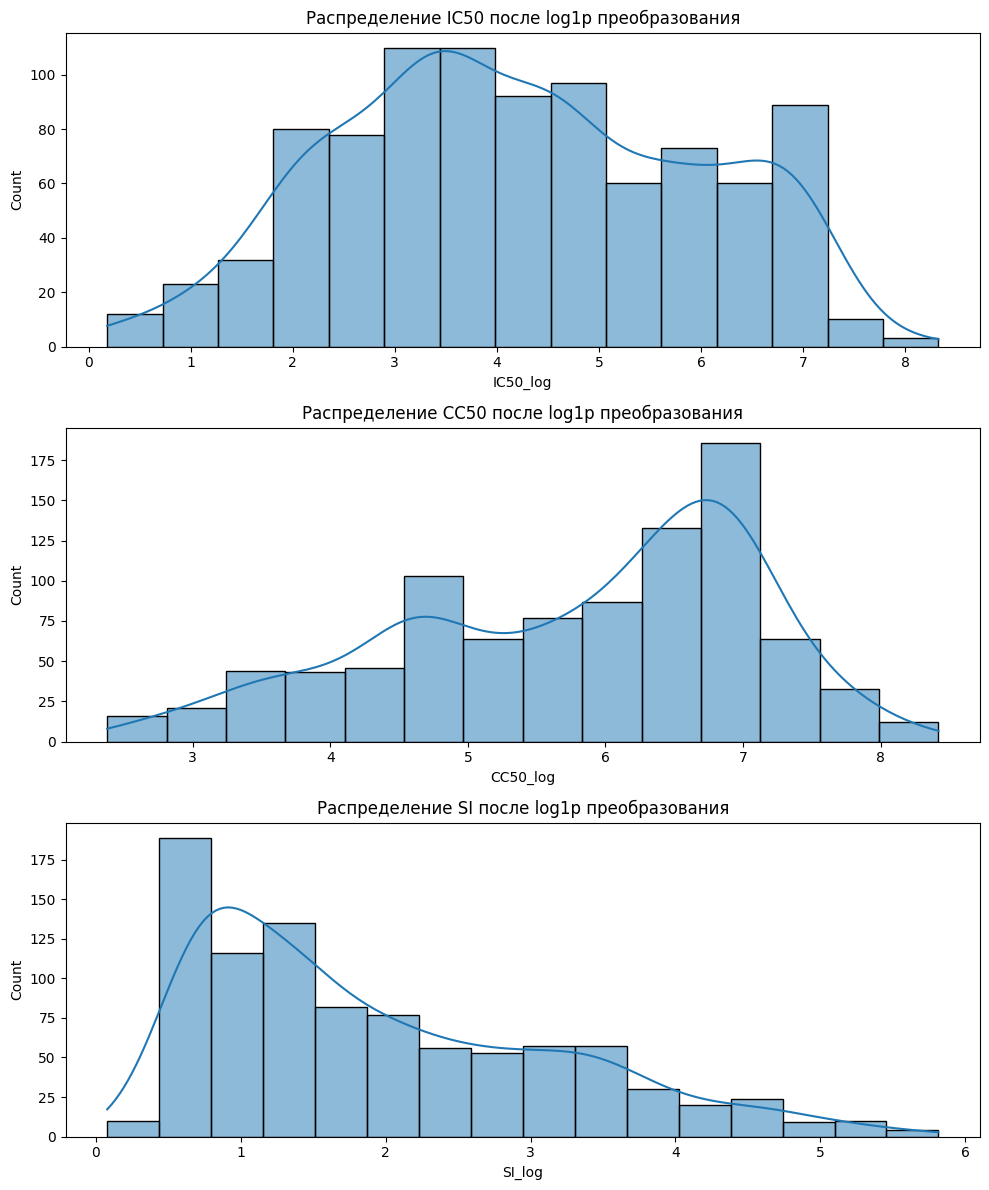

In [31]:
# Создаем графики распределений
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, col in enumerate(['IC50', 'CC50', 'SI']):
    sns.histplot(df_cleaned[f'{col}_log'], kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение {col} после log1p преобразования')
plt.tight_layout()
plt.show()

Перед моделированием мы разделяем данные на три независимых набора, так как:

* SI рассчитывается как CC50/IC50, что создает искусственную зависимость
* Одновременное предсказание всех трех показателей может исказить результаты

In [35]:
# Создаем отдельные датафреймы для каждой целевой переменной
df_ic50 = df_cleaned.drop(columns=['SI_log'])
df_cc50 = df_cleaned.drop(columns=['SI_log'])
df_si = df_cleaned.drop(columns=['IC50_log', 'CC50_log'])

# Сохранение в отдельные файлы
df_ic50.to_csv('data/ic50_data.csv', index=False)
df_cc50.to_csv('data/cc50_data.csv', index=False)
df_si.to_csv('data/si_data.csv', index=False)